# Specify Cuda Device

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

# Import Library

In [2]:

from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import sys
import os
import string, nltk
#nltk.download('stopwords')
nltk.data.path.append("/home/ubuntu/nltk_data")
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
#nltk.download('wordnet')
import numpy as np
import torch
from string import punctuation
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torchinfo import summary
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt


# Load Global variable and Embedding

Use Pretrain Embedding from Glove, at this report, I use two pretrain glove with 100 and 300 dimention

In [3]:
seqence_len = 100
embed_len = 300
Vocab = []
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english') + list(string.punctuation)) 

glove = pd.read_csv('glove.6B.'+str(embed_len)+'d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

# Utils Functions

Create Embedding matrix from pretrain
- By using pretrain Glove, for each word, we map it to a representative vector

Normalization the input text:
- All  stopwords  and  punctuations  are  filter  out
- With  lemmatization,  a  word  returns  an  actual  word  of  thelanguage. It reduces the inflected words properly ensuring thatthe  root  word  belongs  to  the  language

Padding Text
- To let all input sentences have the same length, so that we can train in each batch

In [4]:
def create_embedding_matrix(word_index,embedding_dict,dimension):
    embedding_matrix=np.zeros((len(word_index)+1,dimension))

    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix


def Norm(text,wordnet_lemmatizer,stop_words):
    text = text.lower().strip()
    text =  re.sub(' +', ' ', text)
    word_tokens = word_tokenize(text) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            w = wordnet_lemmatizer.lemmatize(w, pos="v")
            filtered_sentence.append(w) 
    texts=" ".join(str(x) for x in filtered_sentence)
    return text

def pad_text(encoded_reviews, seq_length):
    
    reviews = []
    
    for review in encoded_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(review)) + review)
        
    return np.array(reviews)

def LoadData(file, Vocab=Vocab):
    with open(file, "r",encoding="ISO-8859-1") as f:
        data_x = []
        data_y = []
        contents = f.read().splitlines()
        for line in contents:
            try:
                _,text,label = line.split("#")
            except:
                continue
            text = text.split(" ",1)[1]
            
            text = "".join([ch for ch in text if ch not in punctuation])
            text = Norm(text,wordnet_lemmatizer,stop_words)
            
            data_x.append(text)
            data_y.append(label)
            Vocab = Vocab + text.split(" ")
        return data_x, data_y, Vocab

# Data Preprocessing

In [5]:
train_x, train_y, Vocab = LoadData("../data/train.txt",Vocab)
dev_x, dev_y, Vocab = LoadData("../data/dev.txt",Vocab)
test_x, test_y, Vocab = LoadData("../data/test.txt",Vocab)
print(test_x[:5])

['sandra bullock and hugh grant make a great team but this predictable romantic comedy should get a pink slip', 'those eternally devoted to the insanity of black will have an intermittently good time feel free to go get popcorn whenever hes not onscreen', 'this is wild surreal stuff but brilliant and the camera just kind of sits there and lets you look at this and its like youre going from one room to the next and none of them have any relation to the other', 'this is a harrowing movie about how parents know where all the buttons are and how to push them', 'without shakespeares eloquent language the update is dreary and sluggish']


### Lenght of sentences distribution

(array([ 0.,  1.,  0.,  0.,  0.,  3.,  2.,  0.,  3.,  2.,  1.,  2., 11.,
        10., 13., 15., 11., 15., 12., 18., 19., 18., 24., 29., 20., 28.,
        29., 27., 25., 23., 27., 29., 25., 16., 31., 24., 28., 27., 28.,
        39., 33., 36., 29., 37., 38., 46., 42., 38., 41., 37., 48., 48.,
        35., 56., 35., 49., 56., 38., 40., 43., 39., 47., 47., 56., 44.,
        46., 50., 53., 39., 42., 44., 38., 57., 53., 64., 50., 57., 52.,
        52., 53., 50., 65., 59., 58., 53., 64., 54., 58., 69., 64., 45.,
        70., 74., 57., 49., 59., 53., 48., 54., 55., 73., 64., 68., 49.,
        70., 52., 78., 55., 45., 45., 52., 61., 52., 56., 60., 65., 66.,
        61., 55., 53., 65., 60., 51., 54., 49., 58., 54., 48., 58., 54.,
        53., 37., 53., 36., 46., 53., 52., 41., 42., 45., 44., 52., 60.,
        37., 53., 43., 38., 37., 43., 42., 45., 46., 35., 42., 38., 33.,
        44., 34., 38., 39., 37., 36., 38., 39., 21., 33., 47., 34., 14.,
        20., 23., 22., 34., 26., 19., 21., 22., 19.

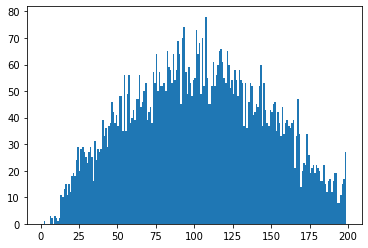

In [6]:
Len_Sentences = [len(x) for x in train_x]
binz = [x for x in range(1,200)]
plt.hist(Len_Sentences, bins=binz)

### Preprocessing data, Setup Dataloader

With this experiment, the data is random load for each batch, do not apply strategy same lenght sentences for each batch

Base on the distribution, the squence_lenght is set to average 100

In [7]:
tokenizer=tf.keras.preprocessing.text.Tokenizer(split=" ")
tokenizer.fit_on_texts(train_x+dev_x+test_x)

encoded_train =tokenizer.texts_to_sequences(train_x)
encoded_dev =tokenizer.texts_to_sequences(dev_x)
encoded_test =tokenizer.texts_to_sequences(test_x)


train_x = pad_text(encoded_train, seq_length = seqence_len)
train_y = np.array([1 if label == "pos" else 0 for label in train_y])


dev_x = pad_text(encoded_dev, seq_length = seqence_len)
dev_y = np.array([1 if label == "pos" else 0 for label in dev_y])


test_x = pad_text(encoded_test, seq_length = seqence_len)
test_y = np.array([1 if label == "pos" else 0 for label in test_y])

# print(len(type(encoded_test)))


train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(dev_x), torch.from_numpy(dev_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 1024
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [8]:


embedding_matrix=create_embedding_matrix(tokenizer.word_index,embedding_dict=glove_embedding,dimension=embed_len)

# Models

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Attention LSTM  -  Basic dot-product

In [157]:
class AttentionLSTM_Dot(nn.Module):
    
    def __init__(self, n_vocab, n_embed, hidden_node, n_output, layers):
        super().__init__()
        
        n_hidden = hidden_node
        self.hidden_node = hidden_node
        self.layers = layers
        
        
        self.linear_hidden_r = nn.Linear(n_hidden, n_hidden)
        self.linear_input_r = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_f = nn.Linear(n_hidden, n_hidden)
        self.linear_input_f = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_g = nn.Linear(n_hidden, n_hidden)
        self.linear_input_g = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_o = nn.Linear(n_hidden, n_hidden)
        self.linear_input_o = nn.Linear(n_embed, n_hidden)
        
        
        self.embedding = nn.Embedding(n_vocab, n_embed)
        
        
        self.fc_out_attent = nn.Linear(n_hidden*2, n_output)
        self.fc_out_lstm = nn.Linear(n_hidden, n_hidden)
        
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.5)
        
    def forward (self, input_words):                                                        # => (batch size, sent len)
        
        hidden_stack = []
        batch = input_words.shape[0]
        seq_lenght= input_words.size(1)
        
        embedded_words = self.embedding(input_words)                                        # => (batch_size, seq_length, n_embed)
        embedded_words = embedded_words.permute(1,0,2)                                      # => (seq_length,batch_size,  n_embed)
        hidden = torch.zeros(input_words.size(0), self.hidden_node).to(device)              # batch-node
        
        c = torch.zeros(input_words.size(0), self.hidden_node).to(device)
        
        for i in range(seq_lenght):                                                         #for i in seq_length

            ir=self.linear_input_r(embedded_words[i])
            hr=self.linear_hidden_r(hidden)
            r= ir.add(hr)
            rt = self.sigmoid(r)
            
            iff=self.linear_input_f(embedded_words[i])
            hff=self.linear_hidden_f(hidden)
            ff= iff.add(hff)
            fft = self.sigmoid(ff)
            
            ig=self.linear_input_g(embedded_words[i])
            hg=self.linear_hidden_g(hidden)
            g= ig.add(hg)
            gt = self.tanh(g)
            
            io=self.linear_input_o(embedded_words[i])
            ho=self.linear_hidden_o(hidden)
            o= io.add(ho)
            ot = self.sigmoid(o)
            
            c = fft*c + rt*gt
            hidden = ot*self.tanh(c)
            
            hidden_stack.append(hidden)
        
        
        final_hidden = self.fc_out_lstm(hidden)                                                      #[batch, hidden-node]
        
        outputs = torch.stack(hidden_stack).permute(1,0,2)                                           #[batch, seq-len, hidden-node]
        
        attention_score = torch.bmm(outputs,final_hidden.view(batch,self.hidden_node,1)).squeeze(2)  # [batch, seq-len, hidden-node] * [batch, hidden-node,1] => [batch, seq-len]
        
        attention_distribution = self.softmax(attention_score)
        
        attention_output = torch.bmm(
            outputs.permute(0,2,1),                                                                  #[batch, hidden-node, seq-len]
            attention_distribution.view(batch,seq_lenght,1)                                          #[batch, seq_len, 1]
        ).squeeze(2)                                                                                 #[batch, hidden-node]
        
        
        out_atten = torch.cat([final_hidden, attention_output],dim=1)                                #[batch, hidden-node*2]  
        out = self.fc_out_attent(out_atten)                                                          #[batch, hidden-node]
        
        sig = self.sigmoid(out)
        return sig, hidden

### Attention LSTM - Multiplicative

Suppose the encoder hidden layer is hidden_node (512)  and the decoder hidden layer is n_hidden_decode (256)

In [158]:


class AttentionLSTM_Multiplicative(nn.Module):
    
    def __init__(self, n_vocab, n_embed, hidden_node, hidden_node_decode, n_output, layers):
        super().__init__()
        
        n_hidden = hidden_node
        n_hidden_decode = int(hidden_node_decode)
        self.hidden_node = hidden_node
        self.hidden_node_decode = int(hidden_node_decode)
        self.layers = layers
        
        
        self.linear_hidden_r = nn.Linear(n_hidden, n_hidden)
        self.linear_input_r = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_f = nn.Linear(n_hidden, n_hidden)
        self.linear_input_f = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_g = nn.Linear(n_hidden, n_hidden)
        self.linear_input_g = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_o = nn.Linear(n_hidden, n_hidden)
        self.linear_input_o = nn.Linear(n_embed, n_hidden)
        
        
        self.embedding = nn.Embedding(n_vocab, n_embed)
        
        self.W_attention = nn.Parameter(torch.zeros([n_hidden_decode, n_hidden], device=device))
        self.b_attention = nn.Parameter(torch.zeros([n_hidden], device=device))
        
        
        self.fc_out_attent = nn.Linear(n_hidden + n_hidden_decode, n_output)
        self.fc_out_lstm = nn.Linear(n_hidden, n_hidden_decode)
        
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.5)
        
    def forward (self, input_words):                                                        # => (batch size, sent len)
        
        hidden_stack = []
        batch = input_words.shape[0]
        seq_lenght= input_words.size(1)
        
        embedded_words = self.embedding(input_words)                                        # => (batch_size, seq_length, n_embed)
        embedded_words = embedded_words.permute(1,0,2)                                      # => (seq_length,batch_size,  n_embed)
        hidden = torch.zeros(input_words.size(0), self.hidden_node).to(device)              # batch-node
        
        c = torch.zeros(input_words.size(0), self.hidden_node).to(device)
        
        for i in range(seq_lenght):                                                         #for i in seq_length

            ir=self.linear_input_r(embedded_words[i])
            hr=self.linear_hidden_r(hidden)
            r= ir.add(hr)
            rt = self.sigmoid(r)
            
            iff=self.linear_input_f(embedded_words[i])
            hff=self.linear_hidden_f(hidden)
            ff= iff.add(hff)
            fft = self.sigmoid(ff)
            
            ig=self.linear_input_g(embedded_words[i])
            hg=self.linear_hidden_g(hidden)
            g= ig.add(hg)
            gt = self.tanh(g)
            
            io=self.linear_input_o(embedded_words[i])
            ho=self.linear_hidden_o(hidden)
            o= io.add(ho)
            ot = self.sigmoid(o)
            
            c = fft*c + rt*gt
            hidden = ot*self.tanh(c)
            
            hidden_stack.append(hidden)
        
        
        final_hidden = self.fc_out_lstm(hidden)                                                      #[batch, hidden-node] => [batch, hidden-node-decode]
        
        outputs = torch.stack(hidden_stack).permute(1,2,0)                                           #[batch, hidden-node, seq-len]
        
        
        
        attention_score = torch.mm(final_hidden,self.W_attention) + self.b_attention                 # [batch,hidden-node-decode]*[hidden-node-decode, hidden-node]  # => [batch, hidden-node]

        attention_score = torch.bmm(attention_score.view(batch,1, self.hidden_node),outputs).squeeze(1)# batch, 1, hidden-node] *[batch, hidden-node, seq-len] => [batch, seq-len]
        
        
        attention_distribution = self.softmax(attention_score)                                       # [batch, seq-len]
        
        attention_output = torch.bmm(
            outputs,                                                                                 #[batch, hidden-node, seq-len]
            attention_distribution.view(batch,seq_lenght,1)                                          #[batch, seq_len, 1]
        ).squeeze(2)                                                                                 #[batch, hidden-node]
        
        
        out_atten = torch.cat([final_hidden, attention_output],dim=1)                                #[batch, hidden-node*2]  
        out = self.fc_out_attent(out_atten)                                                          #[batch, hidden-node]
        
        sig = self.sigmoid(out)
        return sig, hidden

### Attention LSTM - Additive

In [159]:


class AttentionLSTM_Additive(nn.Module):
    
    def __init__(self, n_vocab, n_embed, hidden_node, hidden_node_decode, n_output, layers, v_attention_dimensionality):
        super().__init__()
        
        n_hidden = hidden_node
        n_hidden_decode = int(hidden_node_decode)
        self.hidden_node = hidden_node
        self.hidden_node_decode = int(hidden_node_decode)
        self.layers = layers
        
        
        self.linear_hidden_r = nn.Linear(n_hidden, n_hidden)
        self.linear_input_r = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_f = nn.Linear(n_hidden, n_hidden)
        self.linear_input_f = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_g = nn.Linear(n_hidden, n_hidden)
        self.linear_input_g = nn.Linear(n_embed, n_hidden)

        self.linear_hidden_o = nn.Linear(n_hidden, n_hidden)
        self.linear_input_o = nn.Linear(n_embed, n_hidden)
        
        
        self.embedding = nn.Embedding(n_vocab, n_embed)
        
        # For Additive
        self.linear_additive_h = nn.Linear(n_hidden, v_attention_dimensionality)
        self.linear_additive_s = nn.Linear(n_hidden_decode, v_attention_dimensionality)
        
        self.linear_vdim = nn.Linear(v_attention_dimensionality,1)
        
        #self.W_Vdim = nn.Parameter(torch.zeros([v_attention_dimensionality], device=device))
        
        
        self.fc_out_attent = nn.Linear(n_hidden + n_hidden_decode, n_output)
        self.fc_out_lstm = nn.Linear(n_hidden, n_hidden_decode)
        
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.5)
        
    def forward (self, input_words):                                                        # => (batch size, sent len)
        
        hidden_stack = []
        batch = input_words.shape[0]
        seq_lenght= input_words.size(1)
        
        embedded_words = self.embedding(input_words)                                        # => (batch_size, seq_length, n_embed)
        embedded_words = embedded_words.permute(1,0,2)                                      # => (seq_length,batch_size,  n_embed)
        hidden = torch.zeros(input_words.size(0), self.hidden_node).to(device)              # batch-node
        
        c = torch.zeros(input_words.size(0), self.hidden_node).to(device)
        
        for i in range(seq_lenght):                                                         #for i in seq_length

            ir=self.linear_input_r(embedded_words[i])
            hr=self.linear_hidden_r(hidden)
            r= ir.add(hr)
            rt = self.sigmoid(r)
            
            iff=self.linear_input_f(embedded_words[i])
            hff=self.linear_hidden_f(hidden)
            ff= iff.add(hff)
            fft = self.sigmoid(ff)
            
            ig=self.linear_input_g(embedded_words[i])
            hg=self.linear_hidden_g(hidden)
            g= ig.add(hg)
            gt = self.tanh(g)
            
            io=self.linear_input_o(embedded_words[i])
            ho=self.linear_hidden_o(hidden)
            o= io.add(ho)
            ot = self.sigmoid(o)
            
            c = fft*c + rt*gt
            hidden = ot*self.tanh(c)
            
            hidden_stack.append(hidden)
        
        
        final_hidden = self.fc_out_lstm(hidden)                                                      #[batch, hidden-node] => [batch, hidden-node-decode]
        
        outputs = torch.stack(hidden_stack).permute(1,0,2)                                           #[batch, seq-len, hidden-node]
        
        WH = self.linear_additive_h(outputs)                                                         # => [batch, seq-len, v_dim]

        final_hidden_seq = final_hidden.repeat(1,seq_lenght)                                         #[batch, hidden-node-decode] => [batch, seq-len, hidden-node-decode]
        final_hidden_seq = final_hidden_seq.view(-1,seq_lenght, self.hidden_node_decode)             # ? Right way ? 
        
        
        WS = self.linear_additive_s(final_hidden_seq)                                                # => [batch, seq-len, v_dim]
        
        attention_score = self.tanh(WH+WS)  # => [batch, seq-len, v_dim]
        
        #print(self.W_Vdim.view(v_attention_dimensionality,1).shape)
        #attention_score = torch.mm(attention_score,self.W_Vdim.view(v_attention_dimensionality,1))  #[batch, seq-len]

        attention_score = self.linear_vdim(attention_score).squeeze(2)                               # ? Right way ? [batch, seq-len]
        
        attention_distribution = self.softmax(attention_score)                                       # [batch, seq-len]
        
        attention_output = torch.bmm(
            outputs.permute(0,2,1),                                                                                 #[batch, hidden-node, seq-len]
            attention_distribution.view(batch,seq_lenght,1)                                          #[batch, seq_len, 1]
        ).squeeze(2)                                                                                 #[batch, hidden-node]
        
        
        out_atten = torch.cat([final_hidden, attention_output],dim=1)                                #[batch, hidden-node*2]  
        out = self.fc_out_attent(out_atten)                                                          #[batch, hidden-node]
        
        sig = self.sigmoid(out)
        return sig, hidden

# Training

### Hyper-parameter for tuning

In [166]:
n_vocab=embedding_matrix.shape[0]
n_embed=embedding_matrix.shape[1]
n_hidden = 256
n_output = 1   # 1 ("positive") or 0 ("negative")
layers = 1

### Init Training model

In [167]:
#net = AttentionLSTM_Dot(n_vocab, n_embed, n_hidden, n_output, layers).cuda()

#n_hidden_decode = 256
#net = AttentionLSTM_Multiplicative(n_vocab, n_embed, n_hidden, n_hidden_decode, n_output, layers).cuda()

n_hidden_decode = 512
v_attention_dimensionality = 1024
net = AttentionLSTM_Additive(n_vocab, n_embed, n_hidden, n_hidden_decode, n_output, layers, v_attention_dimensionality).cuda()


criterion = nn.BCELoss()
criterion = criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

print(net)

summary(
    net,
    (1, seqence_len),
    dtypes=[torch.long],
    verbose=2,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
)

AttentionLSTM_Additive(
  (linear_hidden_r): Linear(in_features=256, out_features=256, bias=True)
  (linear_input_r): Linear(in_features=300, out_features=256, bias=True)
  (linear_hidden_f): Linear(in_features=256, out_features=256, bias=True)
  (linear_input_f): Linear(in_features=300, out_features=256, bias=True)
  (linear_hidden_g): Linear(in_features=256, out_features=256, bias=True)
  (linear_input_g): Linear(in_features=300, out_features=256, bias=True)
  (linear_hidden_o): Linear(in_features=256, out_features=256, bias=True)
  (linear_input_o): Linear(in_features=300, out_features=256, bias=True)
  (embedding): Embedding(20451, 300)
  (linear_additive_h): Linear(in_features=256, out_features=1024, bias=True)
  (linear_additive_s): Linear(in_features=512, out_features=1024, bias=True)
  (linear_vdim): Linear(in_features=1024, out_features=1, bias=True)
  (fc_out_attent): Linear(in_features=768, out_features=1, bias=True)
  (fc_out_lstm): Linear(in_features=256, out_features=512,

/home/ubuntu/anaconda3/envs/taco/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
├─Embedding: 1-1                         [300, 20451]     [1, 100, 300]    6,135,300        6,135,300
├─Linear: 1-2                            [300, 256]       [1, 256]         77,056           76,800
├─Linear: 1-3                            [256, 256]       [1, 256]         65,792           65,536
├─Sigmoid: 1-4                           --               [1, 256]         --               --
├─Linear: 1-5                            [300, 256]       [1, 256]         77,056           76,800
├─Linear: 1-6                            [256, 256]       [1, 256]         65,792           65,536
├─Sigmoid: 1-7                           --               [1, 256]         --               --
├─Linear: 1-8                            [300, 256]       [1, 256]         77,056           76,800
├─Linear: 1-9                            [256, 256]       [1, 256]         65,792           65,536
├─Tanh: 1-10

In [168]:
step = 0
n_epochs = 4
clip = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
for epoch in range(n_epochs):
    
    for inputs, labels in train_loader:
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        net.zero_grad()
        output, h = net(inputs)
        try:
            loss = criterion(output.squeeze(), labels.float())
        except:
            output[output < 0.0] = 0.0
            output[output > 1.0] = 1.0
            loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        
        #To prevent exploding gradients
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if (step % 50) == 0:            
            net.eval()
            valid_losses = []
            
            for v_inputs, v_labels in valid_loader:
                v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)

                
                v_output, v_h = net(v_inputs)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())
                
                
            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()))

            
            net.train()
            
#torch.save(net.state_dict(), "LSTM.pt")


cuda


/home/ubuntu/anaconda3/envs/taco/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubuntu/anaconda3/envs/taco/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


# Predict test

In [169]:
net.eval().to(device)
count = 0
sums = 0

for v_inputs, v_labels in test_loader:
    
    sums = sums + len(v_inputs)
    
    v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)

    v_output, v_h = net(v_inputs)
    
    v_loss = criterion(v_output.squeeze(), v_labels.float())
        

    output = torch.round(v_output.squeeze()).detach().cpu().numpy().astype(int)

    ground = v_labels.detach().cpu().numpy().astype(int)

    count = count + np.sum(output == ground)
    
print("Accuracy: " + str(count/len(test_x)))
print(len(test_x))
print(sums)

Accuracy: 0.6270579813886901
1397
1397


/home/ubuntu/anaconda3/envs/taco/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Inference Sample

In [170]:
def inference(net, review, seq_length = 200):
    device = "cuda" #"cuda" if torch.cuda.is_available() else "cpu"
    
    text = review.lower()
    text = "".join([ch for ch in text if ch not in punctuation])
    words = text
    
    encoded_train =tokenizer.texts_to_sequences([words])
    padded_words = pad_text(encoded_train, seq_length = 200)
    padded_words = torch.from_numpy(padded_words).to(device)

    
    net.eval().to(device)
    output, h = net(padded_words )#, h)
    pred = torch.round(output.squeeze())  
    return pred

Test = [
    "It make me happy",
    "Unpleasant viewing experience",
    "I am interested with this assigment",
    "Poor you",
    "Happy new year"
]
for t in Test:
    lab = inference(net, t).tolist()
    if int(lab) == 0:
        print("negative:\t"+t)
    else:
        print("postive:\t"+t)


/home/ubuntu/anaconda3/envs/taco/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


negative:	It make me happy
negative:	Unpleasant viewing experience
postive:	I am interested with this assigment
negative:	Poor you
negative:	Happy new year


In [ ]:
# class NetworkLSTM_(nn.Module):
    
#     def __init__(self, n_vocab, n_embed, hidden_node, n_output, layers):
#         super().__init__()
        
#         self.Wir = nn.Parameter(torch.randn( (n_embed,hidden_node), requires_grad=True, dtype=torch.float))
#         self.Whr = nn.Parameter(torch.randn( (hidden_node,hidden_node) , requires_grad=True, dtype=torch.float))
        
#         self.Wif = nn.Parameter(torch.randn( (n_embed,hidden_node), requires_grad=True, dtype=torch.float))
#         self.Whf = nn.Parameter(torch.randn( (hidden_node,hidden_node) , requires_grad=True, dtype=torch.float))
        
#         self.Wig = nn.Parameter(torch.randn( (n_embed,hidden_node), requires_grad=True, dtype=torch.float))
#         self.Whg = nn.Parameter(torch.randn( (hidden_node,hidden_node) , requires_grad=True, dtype=torch.float))
        
#         self.Wio = nn.Parameter(torch.randn( (n_embed,hidden_node), requires_grad=True, dtype=torch.float))
#         self.Who = nn.Parameter(torch.randn( (hidden_node,hidden_node) , requires_grad=True, dtype=torch.float))
        
#         self.hidden_node = hidden_node
#         self.layers = layers
        
#         self.embedding = nn.Embedding(n_vocab, n_embed)
#         self.fc = nn.Linear(n_hidden, n_output)
#         self.sigmoid = nn.Sigmoid()
#         self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()
#         self.dropout = nn.Dropout(0.5)
        
#     def forward (self, input_words):                    # => (batch size, sent len)
        
#         embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
#         embedded_words = embedded_words.permute(1,0,2)   #  (seq_length,batch_size,  n_embed)
#         hidden = torch.zeros(input_words.size(0), self.hidden_node).to(device)  # batch-node
        
#         c = torch.zeros(input_words.size(0), self.hidden_node).to(device)
        
#         for i in range(input_words.size(1)):           #for i in seq_length

#             ir=embedded_words[i].matmul(self.Wir)
#             hr=hidden.matmul(   self.Whr)
#             r= ir.add(hr)
#             rt = self.sigmoid(r)
            
#             iff=embedded_words[i].matmul(self.Wif)
#             hff=hidden.matmul(   self.Whf)
#             ff= iff.add(hff)
#             fft = self.sigmoid(ff)
            
#             ig=embedded_words[i].matmul(self.Wig)
#             hg=hidden.matmul(   self.Whg)
#             g= ig.add(hg)
#             gt = self.tanh(g)
            
#             io=embedded_words[i].matmul(self.Wio)
#             ho=hidden.matmul(   self.Who)
#             o= io.add(ho)
#             ot = self.sigmoid(o)
            
#             c = fft*c + rt*gt
#             hidden = ot*self.tanh(c)
        
#         out = self.fc(hidden)
        
#         sig = self.sigmoid(out)
#         return sig, hidden
    
# class NetworkGRU_(nn.Module):
    
#     def __init__(self, n_vocab, n_embed, hidden_node, n_output, layers):
#         super().__init__()
        
#         self.Wir = nn.Parameter(torch.randn( (n_embed,hidden_node), requires_grad=True, dtype=torch.float))
#         self.Whr = nn.Parameter(torch.randn( (hidden_node,hidden_node) , requires_grad=True, dtype=torch.float))
        
#         self.Wiz = nn.Parameter(torch.randn( (n_embed,hidden_node), requires_grad=True, dtype=torch.float))
#         self.Whz = nn.Parameter(torch.randn( (hidden_node,hidden_node) , requires_grad=True, dtype=torch.float))
        
#         self.Win = nn.Parameter(torch.randn( (n_embed,hidden_node), requires_grad=True, dtype=torch.float))
#         self.Whn = nn.Parameter(torch.randn( (hidden_node,hidden_node) , requires_grad=True, dtype=torch.float))
        
#         self.hidden_node = hidden_node
#         self.layers = layers
        
#         self.embedding = nn.Embedding(n_vocab, n_embed)
#         self.fc = nn.Linear(n_hidden, n_output)
#         self.sigmoid = nn.Sigmoid()
#         self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()
#         self.dropout = nn.Dropout(0.6)
        
        
#     def forward (self, input_words):                    # => (batch size, sent len)
        
#         embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
#         embedded_words = embedded_words.permute(1,0,2)   #  (seq_length,batch_size,  n_embed)
#         hidden = torch.zeros(input_words.size(0), self.hidden_node).to(device)  # batch-node
        
#         for i in range(input_words.size(1)):           #for i in seq_length

#             ir=embedded_words[i].matmul(self.Wir)
#             hr=hidden.matmul(   self.Whr)
#             r= ir.add(hr)
#             rt = self.sigmoid(r)
            
#             #print(rt.shape)
            
#             iz=embedded_words[i].matmul(self.Wiz)
#             hz=hidden.matmul(   self.Whz)
#             z= iz.add(hz)
#             zt = self.sigmoid(z)
            
#             iN=embedded_words[i].matmul(self.Win)
#             hN=hidden.matmul(   self.Whz)*rt
#             N= iN.add(hN)
#             Nt = self.tanh(N)
            
#             hidden = (1-zt)*Nt + zt*hidden
        
#         out = self.fc(hidden)
        
#         sig = self.sigmoid(out)
#         return sig, hidden